In [3]:
!pip install pandas nltk

In [54]:
import pandas as pd
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def clean_text(text):
    if not isinstance(text, str):
        return ""

    text = text.lower()
    text = re.sub(r'(http\S+|www\S+|https\S+|[@#]\w+)', '', text)
    text = re.sub(r'[“”‘’]', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    tokens = word_tokenize(text)
    tokens = [w for w in tokens if w.isalpha() and w not in stop_words]
    pos_tags = nltk.pos_tag(tokens)
    lemmatized = [lemmatizer.lemmatize(w, get_wordnet_pos(tag)) for w, tag in pos_tags]
    return " ".join(lemmatized)

df = pd.read_csv("chatgpt-reddit-comments.csv")
df["cleaned_comment"] = df["comment_body"].apply(clean_text)
df.to_csv("cleaned_reddit_comments.csv", index=False)
print(df[["comment_body", "cleaned_comment"]].head())

[nltk_data] Downloading package punkt to /Users/zhidi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/zhidi/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /Users/zhidi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/zhidi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


                                        comment_body  \
0  I've been shocked for days now, I don't need c...   
1   \n\nI am so angry right now. I just wasted my...   
2  chatgpt karma whoring is here folks! just when...   
3                                 Worked on me, ngl.   
4  Certified 10/10, must-see moment. It really di...   

                                     cleaned_comment  
0                  ive shock day dont need clickbait  
1  angry right wasted time read post sub clickbai...  
2  chatgpt karma whore folk think stream thought ...  
3                                           work ngl  
4           certify mustsee moment really shock core  


: 

: 

: 

In [55]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(
    max_features=15000,
    ngram_range=(1, 2),      
    min_df=3,                
    max_df=0.9,              
    sublinear_tf=True,       
)
X = vectorizer.fit_transform(df["cleaned_comment"])

: 

: 

: 

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
[nltk_data] Downloading package brown to /Users/zhidi/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt_tab to /Users/zhidi/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/zhidi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Users/zhidi/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package conll2000 to /Users/zhidi/nltk_data...
[nltk_data]   Package conll2000 is already up-to-date!
[nltk_data] Downloading package movie_reviews to
[nltk_data]     /Users/zhidi/nltk_data...
[nltk_

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/zhidi/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


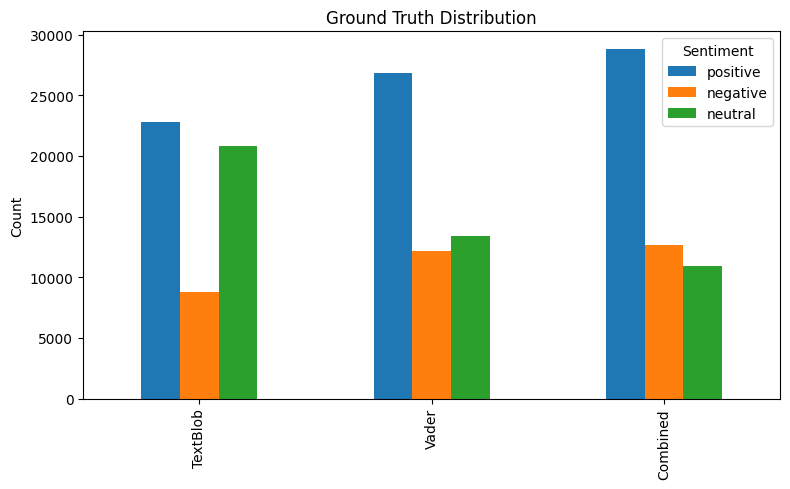

Sentiment labeling completed and saved as 'reddit_with_sentiment_labels.csv'


: 

: 

: 

In [56]:
import sys
!{sys.executable} -m pip install textblob nltk matplotlib pandas
!{sys.executable} -m textblob.download_corpora
nltk.download('vader_lexicon')
from textblob import TextBlob
from nltk.sentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv("cleaned_reddit_comments.csv")

def get_textblob_sentiment(text):
    if not isinstance(text, str) or text.strip() == "":
        return 0
    return TextBlob(text).sentiment.polarity
df['textblob_score'] = df['cleaned_comment'].apply(get_textblob_sentiment)

sia = SentimentIntensityAnalyzer()
def get_vader_sentiment(text):
    if not isinstance(text, str) or text.strip() == "":
        return 0
    return sia.polarity_scores(text)['compound']
df['vader_score'] = df['cleaned_comment'].apply(get_vader_sentiment)

tb = df['textblob_score'].values
vd = df['vader_score'].values
eps = 1e-6
wt_tb = np.abs(tb) / (np.abs(tb) + np.abs(vd) + eps)
wt_vd = 1 - wt_tb
df['combined_score'] = wt_tb*tb + wt_vd*vd

def get_sentiment_label(score):
    if score > 0.05:
        return 'positive'
    elif score < -0.05:
        return 'negative'
    else:
        return 'neutral'

df['textblob_label'] = df['textblob_score'].apply(get_sentiment_label)
df['vader_label'] = df['vader_score'].apply(get_sentiment_label)
df['combined_label'] = df['combined_score'].apply(get_sentiment_label)

label_counts = pd.DataFrame({
    'TextBlob': df['textblob_label'].value_counts(),
    'Vader': df['vader_label'].value_counts(),
    'Combined': df['combined_label'].value_counts()
}).fillna(0)

label_counts = label_counts.T  
label_counts = label_counts[['positive', 'negative', 'neutral']]  

ax = label_counts.plot(      
    kind='bar',
    figsize=(8, 5),
    color=['#1f77b4', '#ff7f0e', '#2ca02c']
)

ax.set_title("Ground Truth Distribution")
ax.set_ylabel("Count")
ax.set_xlabel("")
ax.legend(['positive', 'negative', 'neutral'], title='Sentiment')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha='center')
plt.tight_layout()
plt.show()

df.to_csv("reddit_with_sentiment_labels.csv", index=False)


======== Classification Report ========
              precision    recall  f1-score   support

    negative       0.84      0.66      0.74      2540
     neutral       0.82      0.84      0.83      2180
    positive       0.85      0.93      0.89      5764

    accuracy                           0.84     10484
   macro avg       0.84      0.81      0.82     10484
weighted avg       0.84      0.84      0.84     10484



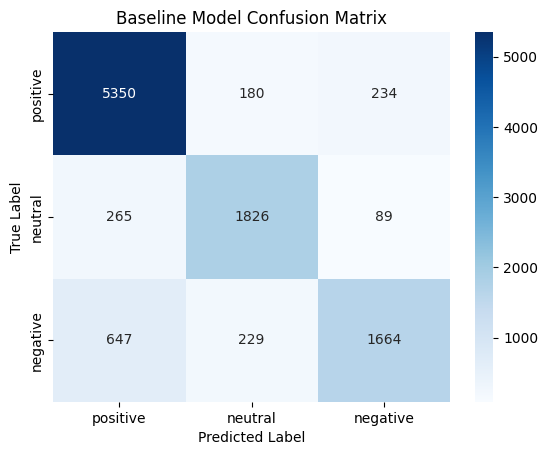

: 

: 

: 

In [57]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

y = df["combined_label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("\n============ Classification Report ============")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred, labels=['positive', 'neutral', 'negative'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['positive','neutral','negative'],
            yticklabels=['positive','neutral','negative'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Baseline Model Confusion Matrix')
plt.show()